# Leverage and the S&P 500

This notebook was inspired by this write-up from Double-Digit Numerics: http://www.ddnum.com/articles/leveragedETFs.php

This isn't investment advice.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
sns.set_theme()
sns.set(rc={'figure.figsize': (13, 5)})

In [3]:
# from: https://www.nasdaq.com/market-activity/index/spx/historical
df = pd.read_csv("HistoricalData_1663390670077.csv")

In [4]:
df.Date = pd.to_datetime(df.Date)
df.rename(columns={"Close/Last": "Price"}, inplace=True)
df.drop(columns=["Volume", "Open", "High", "Low"], inplace=True)
df["Leverage"] = 1.0
df.sort_values(by="Date", kind="heapsort", inplace=True)
df.reset_index(drop=True, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2548 entries, 0 to 2547
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      2548 non-null   datetime64[ns]
 1   Price     2548 non-null   float64       
 2   Leverage  2548 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 59.8 KB


In [6]:
df.Date.min(), df.Date.max()

(Timestamp('2012-09-17 00:00:00'), Timestamp('2022-09-16 00:00:00'))

In [7]:
def sim_levered(leverage, df=df):
    levered_price = ((df.Price / df.Price.shift() - 1) * leverage + 1).cumprod().fillna(1) * df.Price.iloc[0]
    
    # If the levered asset price goes below zero, then the investment is wiped out.
    levered_price *= (levered_price > 0.0).astype(int).cumprod()
    
    return pd.DataFrame({
        "Date": df.Date,
        "Price": levered_price,
        "Leverage": leverage,
    })

In [8]:
def combine_by_leverage(leverages):
    return pd.concat(
        (
            sim_levered(leverage) if leverage != 1.0 else df
            for leverage in leverages
        ),
        ignore_index=True,
    )
    
def plot_by_leverage(leverages):
    dfp = combine_by_leverage(leverages)
    return sns.lineplot(data=dfp, x="Date", y="Price", hue="Leverage", legend="full", palette="tab20")

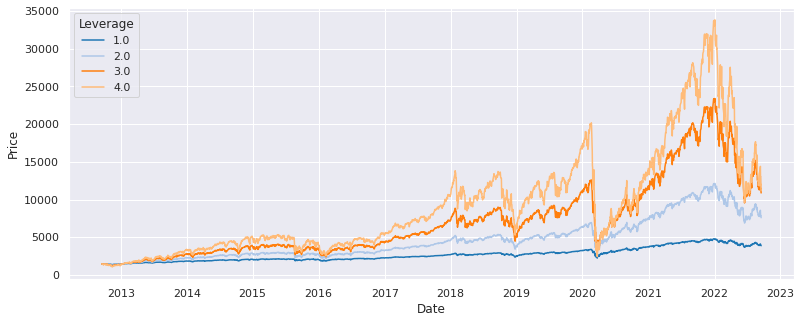

In [9]:
plot_by_leverage([1, 2, 3, 4]);

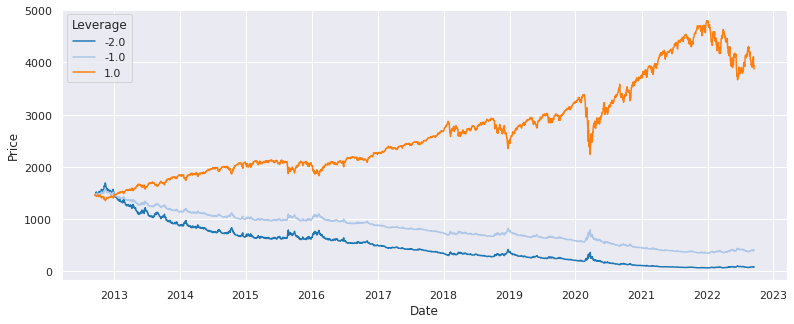

In [10]:
plot_by_leverage([-2, -1, 1]);

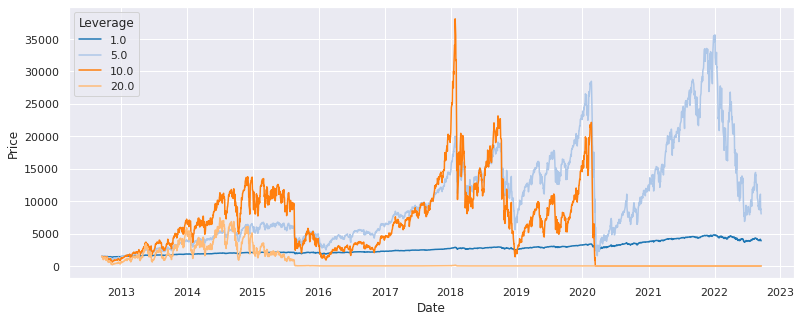

In [11]:
plot_by_leverage([1, 5, 10, 20]);

In [12]:
leverages = np.linspace(-10.0, 10.0, num=20 * 20 + 1)
many_leverages_data = combine_by_leverage(leverages)

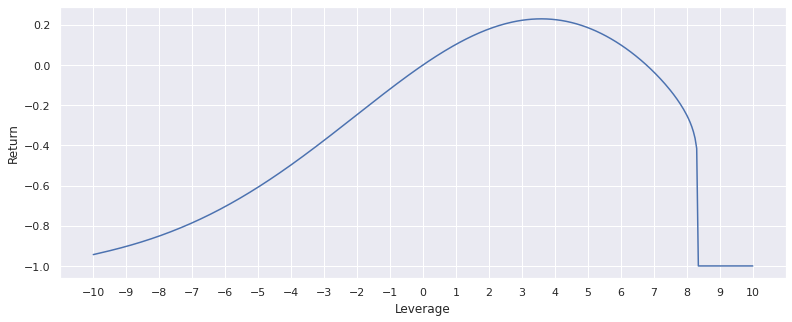

In [13]:
def annual_return(df):
    df = df.iloc[[0, -1]]
    start_date, end_date = df.Date
    start_price, end_price = df.Price
    
    n_years = (end_date - start_date).days / 365
    return np.power(end_price / start_price, 1 / n_years) - 1

return_by_leverage = many_leverages_data.groupby("Leverage") \
    .apply(annual_return).to_frame(name="Return").reset_index()

fig, ax = plt.subplots()
sns.lineplot(data=return_by_leverage, x="Leverage", y="Return", ax=ax)
ax.set_xticks(np.linspace(-10, 10, num=21));